In [26]:
'''@author: Zi Xian Leong (zxleong@psu.edu) '''

import numpy as np
import matplotlib.pyplot as plt
from random import uniform as rand
import scipy.io as sio
import os
from sklearn import preprocessing as pp
from random import randrange
from skimage.transform import rescale, resize
import scipy.ndimage.filters as fil
from random import uniform as rand
import random
from numpy.matlib import repmat
from scipy.signal import tukey
import matplotlib
from sklearn.metrics import r2_score
from matplotlib.ticker import FormatStrFormatter

from sklearn.model_selection import train_test_split
from tqdm import tqdm
# from utils.smooth import smooth, smooth_samedim

from scipy.interpolate import interp1d
import pandas as pd

from scipy.signal import butter, lfilter, sosfilt
import seaborn as sns
import string
from DLcodes.GPRNet import GPRNet

# Figure 7

In [2]:
#%% load and process the field data

#load original raw data
codata = sio.loadmat('Field/Data/rawfielddata/codata.mat')['co_data_cut']

#remove first arrivals
def taper_field(in_array): 
    window = tukey(400,0.3)
    window[100:len(window)]=1
    window = window**4
    out = in_array * window
    return out

codata_tapered = np.apply_along_axis(taper_field,0,codata)

#Apply bandpass
def butter_bandpass(lowcut, highcut, fs, order=5):
    # fs is sample rate in hz
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    # low = lowcut 
    # high = highcut 
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


#Bandpass 
bandpassCODATA = np.apply_along_axis(butter_bandpass_filter,0,codata_tapered,30e6,200e6,1000e6,order=2) #original order was 5, using this!


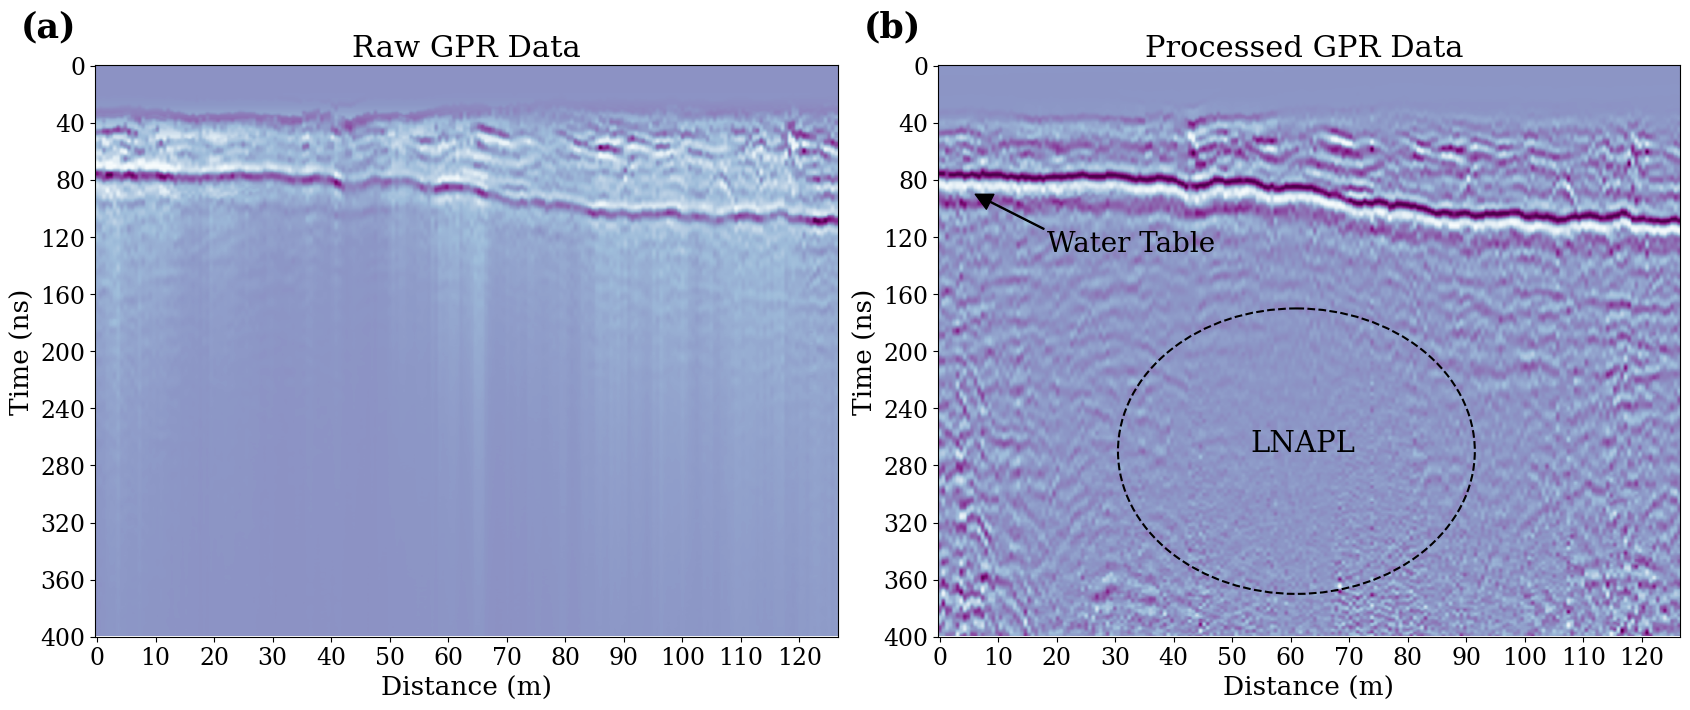

In [3]:
#Apply time gain
dt = np.arange(0,1e-9*400,1e-9)
tfactor = np.exp(dt*1e6)**16 
timegainedCODATA = []
for i in range(208):
    timegainedCODATA.append(bandpassCODATA[:,i]*tfactor)
timegainedCODATA = np.array(timegainedCODATA)

#Apply max normalization
ProcessedFieldData = pp.normalize(timegainedCODATA,norm='max',axis=1)

# np.save('Field/Data/pcsfielddata/ProcessedFieldData_rev.npy',ProcessedFieldData)


from matplotlib.patches import Ellipse
#display
matplotlib.rcdefaults()
matplotlib.rcParams['font.family'] = ['serif']
def figure7():
    fig, axs = plt.subplots(1,2,figsize=(17,8))
    
    xylabelfontsize=19
    tickfontsize=17
    titlefontsize=22
    ft2m = 0.3048
    m2ft = 1/ft2m
    
    ax = axs[0]
    ax.imshow(codata_tapered, cmap='BuPu_r')
    xticks = np.arange(0,208,10*m2ft/2) 
    ax.set_xticks(xticks)
    ax.set_xticklabels(np.arange(0,127,10),fontsize=tickfontsize)
    ax.set_yticks(np.arange(0,420,40))
    ax.set_yticklabels(np.arange(0,420,40),fontsize=tickfontsize)
    ax.set_xlabel('Distance (m)', fontsize=xylabelfontsize)
    ax.set_ylabel('Time (ns)', fontsize=xylabelfontsize)
    ax.set_aspect(0.4)
    # ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.set_title('Raw GPR Data',fontsize=titlefontsize)
    ax.text(-0.1, 1.05, '('+string.ascii_lowercase[0]+')', transform=ax.transAxes, size=25, weight='bold')
#     ax.grid('off')

    ax2 = axs[1]
    ax2.imshow(ProcessedFieldData.T, cmap='BuPu_r')
    xticks = np.arange(0,208,10*m2ft/2) 
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(np.arange(0,127,10),fontsize=tickfontsize)
    ax2.set_xlabel('Distance (m)',fontsize=xylabelfontsize)
    ax2.set_ylabel('Time (ns)', fontsize=xylabelfontsize)
    ax2.set_yticks(np.arange(0,420,40))
    ax2.set_yticklabels(np.arange(0,420,40),fontsize=tickfontsize)
    ax2.set_aspect(0.4)
    ax2.set_title('Processed GPR Data ',fontsize=titlefontsize)
    ax2.text(-0.1, 1.05, '('+string.ascii_lowercase[1]+')', transform=ax2.transAxes, size=25, weight='bold')
#     ax2.grid('off')
    ax2.annotate('Water Table',xy=(10,90),xytext=(30,130),arrowprops = dict(facecolor ='black',width=0.7),fontsize=20)
    ax2.text(x=87,y=270,s='LNAPL',fontsize=21)
    mean = [ 100 ,  270]
    width = 100
    height = 200
    # angle = -54
    ell = Ellipse(xy=mean, width=width, height=height,facecolor='none', edgecolor='black', lw=1.5, ls='--')
    ax2.add_patch(ell)
    fig.tight_layout()
    
figure7()

# Figure 8

In [21]:
#%% Field data prediction

# weights_path = 'Weights/weight_GPRNet_n32k10.h5'

# cnn_model = GPRNet(im_width=1, im_height=400, neurons=32, kern_sz = 10,enable_dropout=False)
# cnn_model.load_weights(weights_path)

In [14]:
#Predict
# FieldPrediction = np.squeeze(cnn_model.predict(np.expand_dims(ProcessedFieldData,axis=2)),axis=2) 

#Save and Load
# np.save('Field/Data/prediction/FieldPrediction_rev.npy',FieldPrediction)
FieldPrediction = np.load('Field/Data/prediction/FieldPrediction_rev.npy')

#Add smoothing
smoothed_model = fil.gaussian_filter(FieldPrediction,sigma=(3,0))

In [16]:
#convert to spatial domain
dt=1e-9
vel_dd_img = []
z_stack_length = []
for i in range(208):
    vel_line = FieldPrediction.T[:,i]*1e9
    depth_z = np.cumsum(vel_line * dt, axis=0) / 2
    depth_z = np.insert(depth_z[:399],0,0,axis=0)
    max_depth = np.max(depth_z)
    dest_depth = np.arange(0,max_depth,0.05)
    vel_dd = interp1d(depth_z, vel_line,kind='linear',bounds_error=False,fill_value=np.nan,axis=0)(dest_depth)
    vel_dd_img.append(vel_dd)
    z_stack_length.append(len(dest_depth))
vel_dd_img = np.array(vel_dd_img)
z_stack_length = np.array(z_stack_length)

canvas = np.tile(np.nan,(np.max(z_stack_length),208))

for i in range(208):
    lengthOfEachLine = len(vel_dd_img[i])
    canvas[:lengthOfEachLine,i]=vel_dd_img[i]

min_z = np.min(z_stack_length)

canvas_cut = []
for i in range(208):
    canvas_cut.append(canvas[:min_z-1,i])
canvas_cut  = np.array(canvas_cut) #bear in mind this is the velocity model

ep = 299792500**2 / canvas_cut**2 #convert to ep

#save
# ep_fieldprediction = sio.savemat('Field/Data/prediction/ep_FieldPrediction_rev.mat',{'ep':ep})


<ipython-input-16-84d2b4ed17f2>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  vel_dd_img = np.array(vel_dd_img)


###  Now, run FD_Prediction_rev.m to generate predicted forward gather

In [18]:
#Process Forward data
#process stacked 1D forward data - downsample, remove first arrival, time gain, max norm

stacked1D = sio.loadmat('Field/Data/prediction/rawgather_Stacked1D_fieldprediction_rev.mat')['Stacked_1D']

#downsample
scale = 20
field_dest_tt = np.arange(0,1e-9*400,1e-9)
field_ori_tt = np.arange(0,(400*scale)*(1e-9/scale),1e-9/scale)
stacked1D_interp=[]
for i in range(207):
    line_interp = interp1d(field_ori_tt,stacked1D[:,i],kind='linear',fill_value='extrapolate')(field_dest_tt)
    stacked1D_interp.append(line_interp)
stacked1D_interp = np.array(stacked1D_interp)

#remove first arrival
stacked1D_recover = np.apply_along_axis(taper_field,1,stacked1D_interp)

#time gain
tfactor_1d = np.exp(np.arange(0,1e-9*400,1e-9) * 1e6) ** 5
fd_1d_stacked = []
for i in range(207):
    fd_1d_stacked.append(stacked1D_recover[i,:]*tfactor_1d)
fd_1d_stacked = np.array(fd_1d_stacked)

#max normalization
ForwDataFrPred = pp.normalize(fd_1d_stacked,norm='max',axis=1)

#save
# np.save('Field/Data/prediction/ForwDataFrPred_rev.npy',ForwDataFrPred)

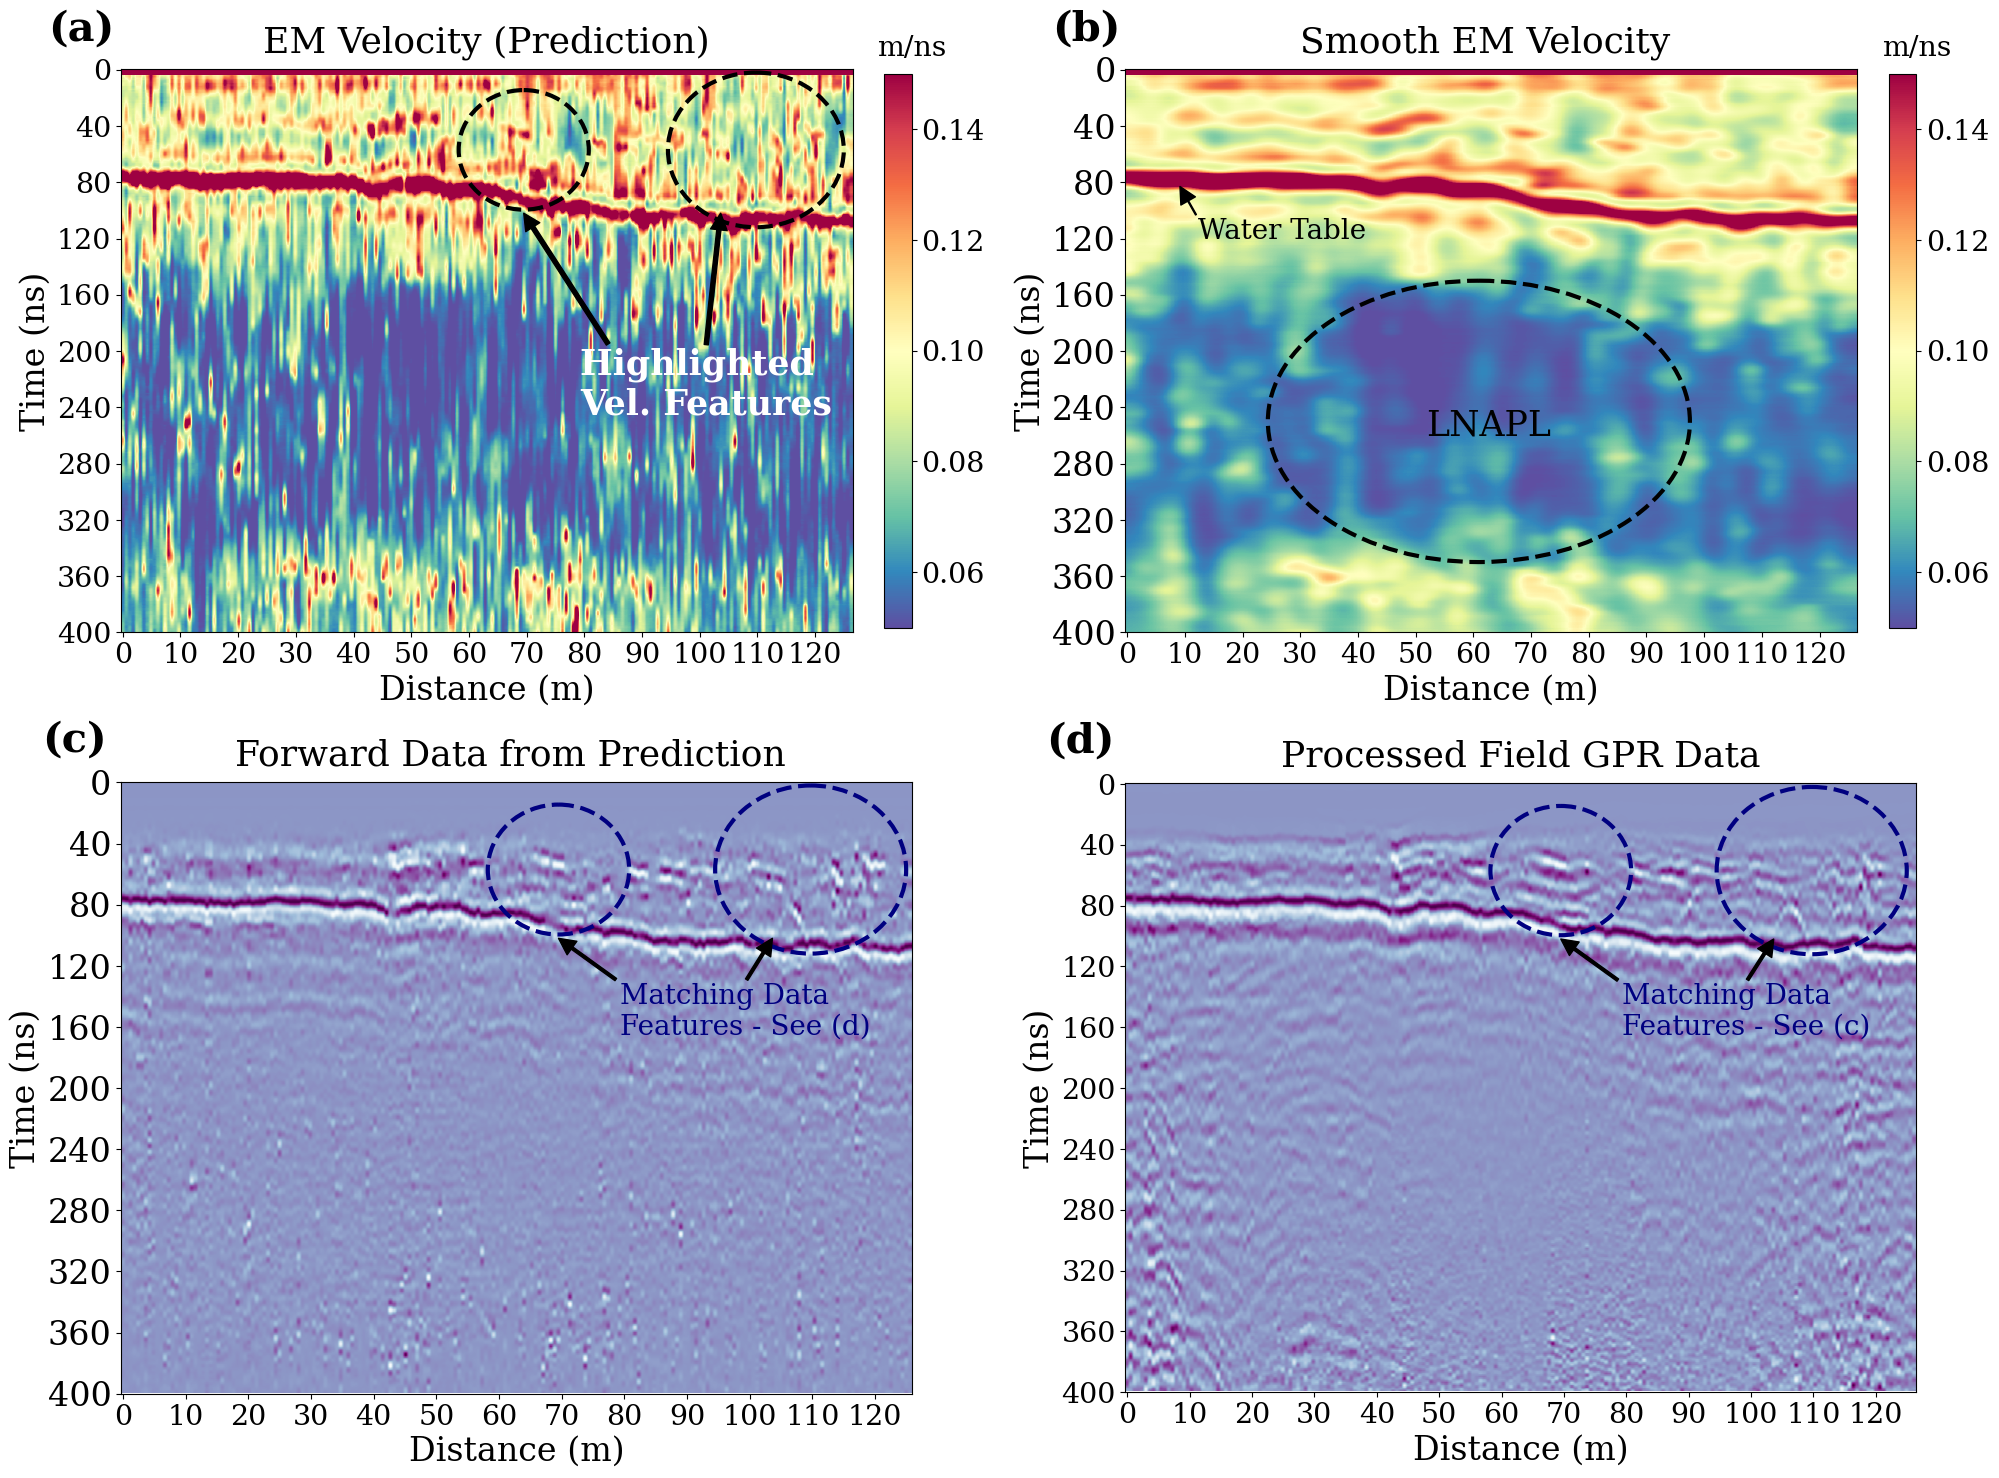

In [20]:
#%% Produces Figure 8

matplotlib.rcdefaults()
matplotlib.rcParams['font.family'] = ['serif']

def figure8(wspace=0.1,hspace=0.05):
    fig, axs = plt.subplots(2,2,figsize=(20,15))
    
    xylabelfontsize=24
    tickfontsize=20.5
    titlefontsize=26
    titlePadSize=12
    subtilteFontSize = 30
    ft2m = 0.3048
    m2ft = 1/ft2m
    
    # Field Prediction
    ax = axs[0,0]
    im = ax.imshow(FieldPrediction.T, cmap='Spectral_r',vmin=0.05,vmax=0.15)
    xticks = np.arange(0,208,10*m2ft/2) 
    ax.set_xticks(xticks)
    ax.set_xticklabels(np.arange(0,127,10),fontsize=tickfontsize)
    ax.set_yticks(np.arange(0,420,40))
    ax.set_yticklabels(np.arange(0,420,40),fontsize=tickfontsize)
    ax.set_xlabel('Distance (m)', fontsize=xylabelfontsize)
    ax.set_ylabel('Time (ns)', fontsize=xylabelfontsize)
    ax.set_aspect(0.4)
    cbar = fig.colorbar(im, ax=ax,fraction=0.035, pad=0.04)
    cbar.ax.tick_params(labelsize=tickfontsize)
    cbar.ax.set_xlabel('m/ns',fontsize=tickfontsize)
    cbar.ax.xaxis.set_label_coords(1,1.07)
    ax.set_title('EM Velocity (Prediction)',fontsize=titlefontsize,pad=titlePadSize)
    ax.text(-0.1, 1.05, '('+string.ascii_lowercase[0]+')', transform=ax.transAxes, size=subtilteFontSize, weight='bold')
    mean = [ 180 ,  57]
    width = 50
    height = 110
    ell = Ellipse(xy=mean, width=width, height=height,facecolor='none', edgecolor='black', lw=3, ls='--')
    ax.add_patch(ell)    
    mean2 = [ 114 ,  57]
    width2 = 37
    height2 = 85
    ell2 = Ellipse(xy=mean2, width=width2, height=height2,facecolor='none', edgecolor='black', lw=3, ls='--')
    ax.add_patch(ell2)
    ax.annotate('Highlighted \nVel. Features',xy=(170,102),xytext=(130,245),
                  arrowprops = dict(facecolor ='black',width=3),
                  fontsize=25, color='white', fontweight='bold')
    ax.annotate('',xy=(114,102),xytext=(138,195),
                 arrowprops = dict(facecolor ='black',width=3),fontsize=20, color='black')
    
    # Smoothed Model
    ax2 = axs[0,1]
    im2 = ax2.imshow(smoothed_model.T, cmap='Spectral_r',vmin=0.05,vmax=0.15)
    xticks = np.arange(0,208,10*m2ft/2) 
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(np.arange(0,127,10),fontsize=tickfontsize)
    ax2.set_xlabel('Distance (m)',fontsize=xylabelfontsize)
    ax2.set_ylabel('Time (ns)', fontsize=xylabelfontsize)
    ax2.set_yticks(np.arange(0,420,40)) #dz is 0.05, that means every 20 cell is 1m
    ax2.set_yticklabels(np.arange(0,420,40), fontsize=xylabelfontsize)
    ax2.set_aspect(aspect=0.4)
    ax2.set_title('Smooth EM Velocity ',fontsize=titlefontsize,pad=titlePadSize)
    ax2.text(-0.1, 1.05, '('+string.ascii_lowercase[1]+')', transform=ax2.transAxes, size=subtilteFontSize, weight='bold')
    cbar2 = fig.colorbar(im2, ax=ax2,fraction=0.035, pad=0.04)
    cbar2.ax.tick_params(labelsize=tickfontsize)
    cbar2.ax.set_xlabel('m/ns',fontsize=tickfontsize)
    cbar2.ax.xaxis.set_label_coords(1,1.07)
    ax2.annotate('Water Table',xy=(15,83),xytext=(20,120),arrowprops = dict(facecolor ='black',width=0.7),fontsize=20)
    ax2.text(x=85,y=260,s='LNAPL',fontsize=25, color='black',fontweight='normal')
    mean = [ 100 ,  250]
    width = 120
    height = 200
    ell = Ellipse(xy=mean, width=width, height=height,facecolor='none', edgecolor='black', lw=3, ls='--')
    ax2.add_patch(ell)


    # Forward Data from Prediction
    ax3 = axs[1,0]
    ax3.imshow(ForwDataFrPred.T, cmap='BuPu_r')
    xticks = np.arange(0,208,10*m2ft/2) 
    ax3.set_xticks(xticks)
    ax3.set_xticklabels(np.arange(0,127,10),fontsize=tickfontsize)
    ax3.set_xlabel('Distance (m)',fontsize=xylabelfontsize)
    ax3.set_ylabel('Time (ns)', fontsize=xylabelfontsize)
    ax3.set_yticks(np.arange(0,420,40)) #dz is 0.05, that means every 20 cell is 1m
    ax3.set_yticklabels(np.arange(0,420,40), fontsize=xylabelfontsize)
    ax3.set_aspect(0.4)
    ax3.set_title('Forward Data from Prediction ',fontsize=titlefontsize,pad=titlePadSize)
    ax3.text(-0.1, 1.05, '('+string.ascii_lowercase[2]+')', transform=ax3.transAxes, size=subtilteFontSize, weight='bold')
    mean = [ 180 ,  57]
    width = 50
    height = 110
    ell = Ellipse(xy=mean, width=width, height=height,facecolor='none', edgecolor='navy', lw=3, ls='--')
    ax3.add_patch(ell)    
    mean2 = [ 114 ,  57]
    width2 = 37
    height2 = 85
    ell2 = Ellipse(xy=mean2, width=width2, height=height2,facecolor='none', edgecolor='navy', lw=3, ls='--')
    ax3.add_patch(ell2)
    ax3.annotate('Matching Data \nFeatures - See (d)',xy=(170,102),xytext=(130,165),
                 arrowprops = dict(facecolor ='black',width=2),fontsize=20, color='navy')
    ax3.annotate('',xy=(114,102),xytext=(129,129),
                 arrowprops = dict(facecolor ='black',width=2),fontsize=20, color='navy')
    
    # Processed Field Data
    ax4 = axs[1,1]
    ax4.imshow(ProcessedFieldData.T, cmap='BuPu_r')
    xticks = np.arange(0,208,10*m2ft/2) 
    ax4.set_xticks(xticks)
    ax4.set_xticklabels(np.arange(0,127,10),fontsize=tickfontsize)
    ax4.set_xlabel('Distance (m)',fontsize=xylabelfontsize)
    ax4.set_ylabel('Time (ns)', fontsize=xylabelfontsize)
    ax4.set_yticks(np.arange(0,420,40))
    ax4.set_yticklabels(np.arange(0,420,40),fontsize=tickfontsize)
    ax4.set_aspect(0.4)
    ax4.set_title('Processed Field GPR Data',fontsize=titlefontsize,pad=titlePadSize)
    ax4.text(-0.1, 1.05, '('+string.ascii_lowercase[3]+')', transform=ax4.transAxes, size=subtilteFontSize, weight='bold')
    mean = [ 180 ,  57]
    width = 50
    height = 110
    ell = Ellipse(xy=mean, width=width, height=height,facecolor='none', edgecolor='navy', lw=3, ls='--')
    mean2 = [ 114 ,  57]
    width2 = 37
    height2 = 85
    ell2 = Ellipse(xy=mean2, width=width2, height=height2,facecolor='none', edgecolor='navy', lw=3, ls='--')
    ax4.add_patch(ell2)
    ax4.add_patch(ell)    
    ax4.annotate('Matching Data \nFeatures - See (c)',xy=(170,102),xytext=(130,165),
                 arrowprops = dict(facecolor ='black',width=2),fontsize=20, color='navy')
    ax4.annotate('',xy=(114,102),xytext=(129,129),
                 arrowprops = dict(facecolor ='black',width=2),fontsize=20, color='navy')
    fig.tight_layout()
    plt.subplots_adjust(wspace=wspace, hspace=hspace)
    
figure8(wspace=0.27, hspace=0.2)

# Figure 9

In [21]:
#%% convert to spatial domain
ft2m = 0.3048
m2ft = 1/ft2m

def convert2depth(in_img):
    dt=1e-9
    vel_dd_img_wtg = []
    z_stack_length = []
    for i in range(208):
        vel_line = in_img[:,i]
        depth_z = np.cumsum(vel_line * dt, axis=0) / 2
        depth_z = np.insert(depth_z[:399],0,0,axis=0)
        max_depth = np.max(depth_z)
        dest_depth = np.arange(0,max_depth,0.05)
        vel_dd = interp1d(depth_z, vel_line,kind='linear',bounds_error=False,fill_value=np.nan,axis=0)(dest_depth)
        vel_dd_img_wtg.append(vel_dd)
        z_stack_length.append(len(dest_depth))
    vel_dd_img_wtg = np.array(vel_dd_img_wtg)
    z_stack_length = np.array(z_stack_length)
    
    canvas_wtg = np.tile(np.nan,(np.max(z_stack_length),208))
    
    for i in range(208):
        lengthOfEachLine = len(vel_dd_img_wtg[i])
        canvas_wtg[:lengthOfEachLine,i]=vel_dd_img_wtg[i] 
    min_z = np.min(z_stack_length)

    return canvas_wtg, min_z

smoothed_model_dd, min_z = convert2depth(smoothed_model.T*1e9)

<ipython-input-21-594e59f93ef7>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  vel_dd_img_wtg = np.array(vel_dd_img_wtg)


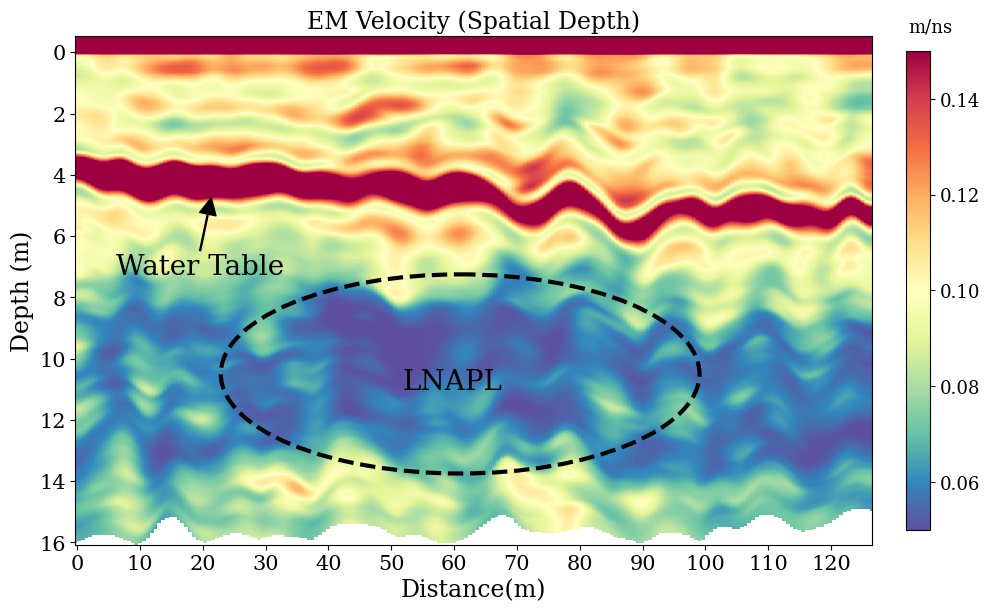

In [22]:
matplotlib.rcdefaults()
matplotlib.rcParams['font.family'] = ['serif']

fig = plt.figure(figsize=(10,8))
ax = plt.gca()
im = ax.imshow(smoothed_model_dd/1e9,cmap='Spectral_r',vmax=0.15,vmin=0.05)
ax.set_aspect(0.4)
xticks = np.arange(0,208,10*m2ft/2) 
ax.set_xticks(xticks)
ax.set_xticklabels(np.arange(0,127,10),fontsize=15)
ax.set_xlabel('Distance(m)',fontsize=17)
ax.set_yticks(np.arange(10,370,40)) #dz is 0.05, that means every 20 cell is 1m
ax.set_yticklabels(np.arange(0,18,2),fontsize=15)
ax.set_ylabel('Depth (m)',fontsize=17)
ax.set_title('EM Velocity (Spatial Depth)',fontsize=17)
cbar = fig.colorbar(im, ax=ax,fraction=0.028, pad=0.04)
cbar.ax.xaxis.set_label_coords(1,1.07)
cbar.ax.set_xlabel('m/ns',fontsize=13)
cbar.ax.tick_params(labelsize=13)
mean = [ 100 ,  220]
width = 125
height = 130
ell = Ellipse(xy=mean, width=width, height=height,facecolor='none', edgecolor='black', lw=3, ls='--')
ax.add_patch(ell)
ax.text(x=85,y=230,s='LNAPL',fontsize=20, color='black',fontweight='normal')
ax.annotate('Water Table',xy=(35,105),xytext=(10,155),arrowprops = dict(facecolor ='black',width=0.7),fontsize=20)
plt.tight_layout()    

# Figure 10

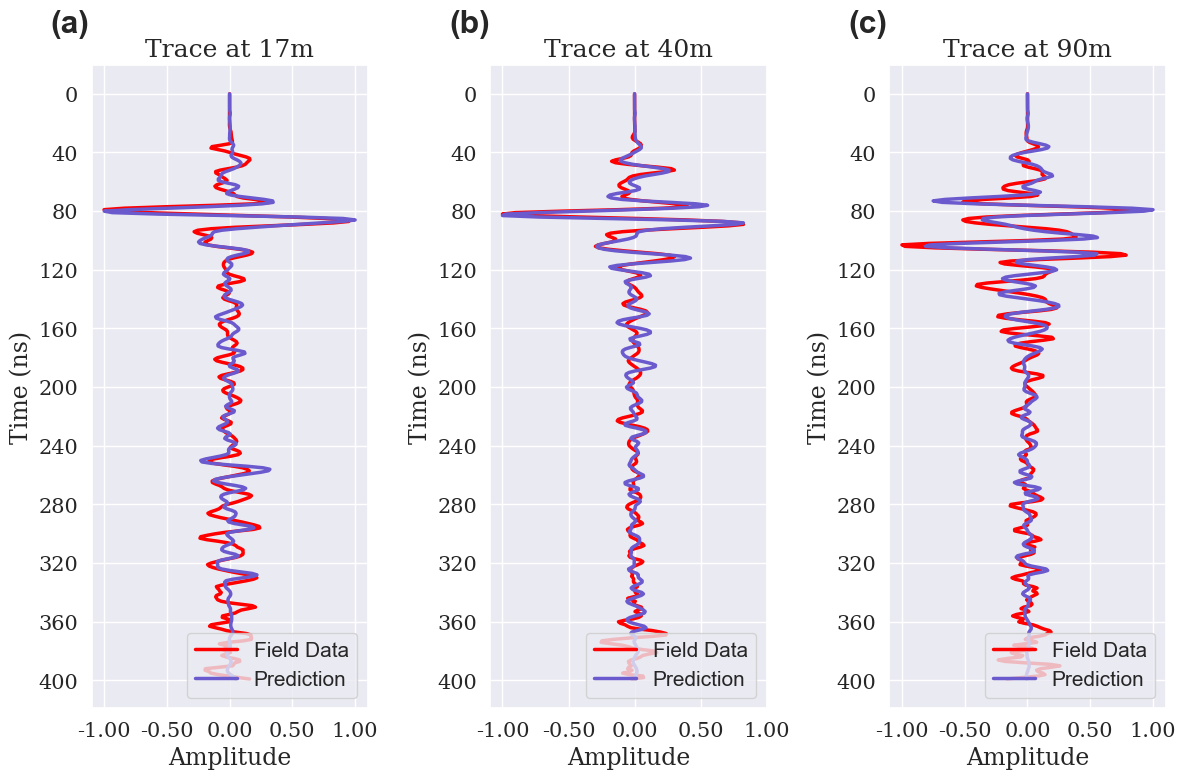

In [35]:
## Load back if necessary
# ProcessedFieldData = np.load('Field/Data/pcsfielddata/ProcessedFieldData_rev.npy')
# FieldPrediction = np.load('Field/Data/preduiction/FieldPrediction_rev.npy')
# smoothed_model = fil.gaussian_filter(FieldPrediction,sigma=(3,0))
# ForwDataFrPred = np.load('Field/Data/preduiction/ForwDataFrPred_rev.npy')


#%%display
best_ind = [29,67,148] #select some traces to display
m2ft = 1/0.3048
#at every 1.64 = 1 m
#display

# matplotlib.rcdefaults()
matplotlib.rcParams['font.family'] = ['serif']
def figure10():

    fig,axs = plt.subplots(1,3,figsize=(12,8))
    fig.tight_layout()
    sns.set_theme(style='darkgrid')
    
    for i in range(len(best_ind)):
        ax = axs[i]
        ax.set_anchor('C')
        ax.invert_yaxis()  
        ax.plot(ProcessedFieldData[best_ind[i]],np.arange(len(ProcessedFieldData[i])),label='Field Data', color='red', linewidth=2.5)
        ax.plot(ForwDataFrPred[best_ind[i]],np.arange(len(ForwDataFrPred[i])),label='Prediction', color='slateblue', linewidth=2.5)
        ax.set_title('Trace at {}m'.format(int(best_ind[i]/(m2ft/2))),fontsize=18)
        ax.set_xlabel('Amplitude', fontsize=17)
        ax.set_ylabel('Time (ns)', fontsize=17)
        ax.set_xticks(np.arange(-1,1.5,0.5))
        ax.set_xticklabels(np.arange(-1,1.5,0.5),fontsize=15)
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.set_yticks(np.arange(0,440,40))
        ax.set_yticklabels(np.arange(0,440,40),fontsize=15)
        ax.legend(loc=4,fontsize=15)
        ax.text(-0.15, 1.05, '('+string.ascii_lowercase[i]+')', transform=ax.transAxes, size=23, weight='bold')
    fig.tight_layout()
    
figure10()